In [6]:
import sys
sys.path.insert(0,"../../../utilities/")
import data_utils
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.backends.backend_pdf
import seaborn as sns
import scipy.stats as st
import scipy.sparse as sp
import math

In [ ]:
compartments = pd.read_csv("../../../data/K562/hg38/annotations/compartments.bg", sep = "\t", header = None)
compartments.columns = ['chr_name', 'start', 'end', 'c']
compartments = compartments[compartments.loc[:,'chr_name']=='chr21']
compartments_vector = sum([[c]*10 for c in compartments.loc[:,'c']],[])

In [62]:
def read_hic(infile):
    hic_data = pd.read_csv(infile, sep = "\t", header = None)
    hic_data = hic_data.dropna()
    hic_data.columns = ["source", "target", "weight"]
    hic_data['s'] = [int(s/25000) for s in hic_data['source']]
    hic_data['t'] = [int(t/25000) for t in hic_data['target']]
    hic_data['dist'] = [abs(s-t) for s,t in zip(hic_data['s'],hic_data['t'])]
    hic_data['log2_weight'] = np.log2(hic_data['weight'])
    min_w = hic_data['log2_weight'].min()
    max_w = hic_data['log2_weight'].max()
    w_cuts = np.linspace(min_w, max_w, 200)
    hic_data['binned_weight'] = np.digitize(hic_data['log2_weight'], bins = w_cuts)
    hic_data.loc[:,'s_c'] = [compartments_vector[p] for p in hic_data.loc[:,'s']]
    hic_data.loc[:,'t_c'] = [compartments_vector[p] for p in hic_data.loc[:,'t']]
    hic_data.loc[:,'c_diff'] = abs(hic_data.loc[:,'s_c'] - hic_data.loc[:,'t_c'])
    return hic_data

In [63]:
vc_chr21_hic = read_hic("../../../data/K562/hg38/Hi-C/oe_25000_VC/chr21_chr21.txt")
kr_chr21_hic = read_hic("../../../data/K562/hg38/Hi-C/oe_25000_KR/chr21_chr21.txt")

<AxesSubplot:xlabel='binned_weight', ylabel='c_diff'>

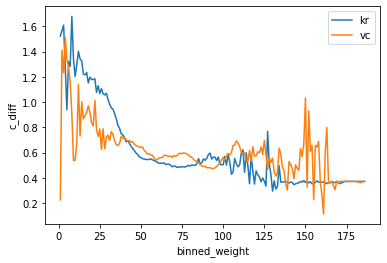

In [81]:
kr_binned_weight = kr_chr21_hic.groupby('binned_weight').agg({'c_diff':'mean'}).reset_index()
vc_binned_weight = vc_chr21_hic.groupby('binned_weight').agg({'c_diff':'mean'}).reset_index()
l = 0
u = 200
sns.lineplot(x=kr_binned_weight['binned_weight'][l:u], y=kr_binned_weight['c_diff'][l:u], label = 'kr')
sns.lineplot(x=vc_binned_weight['binned_weight'][l:u], y=vc_binned_weight['c_diff'][l:u], label = 'vc')

In [9]:
vc_weights = vc_chr21_hic.groupby('dist')['weight'].mean().reset_index()
kr_weights = kr_chr21_hic.groupby('dist')['weight'].mean().reset_index()

<AxesSubplot:xlabel='dist', ylabel='weight'>

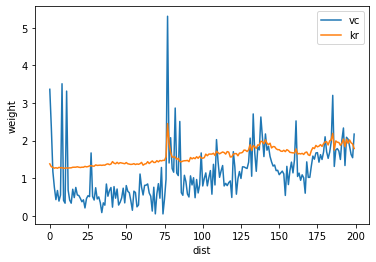

In [10]:
l = 0
u = 200
sns.lineplot(x=vc_weights['dist'][l:u], y=vc_weights['weight'][l:u], label = 'vc')
sns.lineplot(x=kr_weights['dist'][l:u], y=kr_weights['weight'][l:u], label = 'kr')

Text(0.5, 1.0, 'normalized with KR')

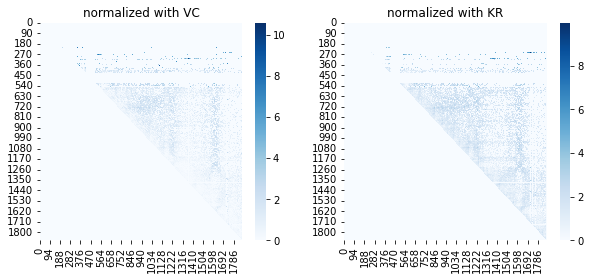

In [84]:
chr21_size = math.ceil(data_utils.hg38_chr_sizes['chr21']/25000)
vc_chr21_hic_mat = sp.csr_matrix((vc_chr21_hic['weight'],(vc_chr21_hic['s'],vc_chr21_hic['t'])), 
                                 shape=(chr21_size,chr21_size))
kr_chr21_hic_mat = sp.csr_matrix((kr_chr21_hic['weight'],(kr_chr21_hic['s'],kr_chr21_hic['t'])), 
                                 shape=(chr21_size,chr21_size))
fig, axs = plt.subplots(1, 2, figsize = (10,4))
sns.heatmap(np.arcsinh(vc_chr21_hic_mat.toarray()), ax = axs[0], cmap = 'Blues')
axs[0].set_title('normalized with VC')
sns.heatmap(np.arcsinh(kr_chr21_hic_mat.toarray()), ax = axs[1], cmap = 'Blues')
axs[1].set_title('normalized with KR')


In [45]:
vc_chr21_hic.columns = ['source', 'target', 'weight']
vc_weights = np.log2(vc_chr21_hic['weight'])
vc_dist_params = st.exponweib.fit(vc_weights)
vc_p_values = 1 - st.exponweib.cdf(vc_weights, vc_dist_params[0], vc_dist_params[1], vc_dist_params[2], vc_dist_params[3])
vc_chr21_hic['weibull p-value'] = vc_p_values

In [48]:
kr_chr21_hic.columns = ['source', 'target', 'weight']
kr_chr21_hic = kr_chr21_hic.dropna()
kr_weights = np.log2(kr_chr21_hic['weight'])
kr_dist_params = st.exponweib.fit(kr_weights)
kr_p_values = 1 - st.exponweib.cdf(kr_weights, kr_dist_params[0], kr_dist_params[1], kr_dist_params[2], kr_dist_params[3])
kr_chr21_hic['weibull p-value'] = kr_p_values

/home/nedooshki/miniconda3/envs/embedding/lib/python3.6/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/nedooshki/miniconda3/envs/embedding/lib/python3.6/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, 'normalized with kr')

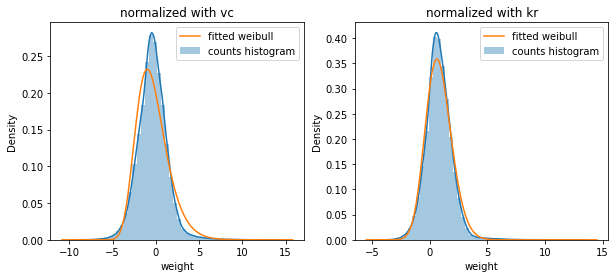

In [50]:
fig, axs = plt.subplots(1,2,figsize=(10,4))

sns.distplot(vc_weights,label='counts histogram', ax = axs[0])
x_min, x_max = axs[0].get_xlim()
xs = np.linspace(x_min, x_max, 200)
ys = st.exponweib.pdf(xs, vc_dist_params[0], vc_dist_params[1], vc_dist_params[2], vc_dist_params[3])
sns.lineplot(x=xs, y=ys,label='fitted weibull', ax = axs[0])
axs[0].set_title('normalized with vc')

sns.distplot(kr_weights,label='counts histogram', ax = axs[1])
x_min, x_max = axs[1].get_xlim()
xs = np.linspace(x_min, x_max, 200)
ys = st.exponweib.pdf(xs, kr_dist_params[0], kr_dist_params[1], kr_dist_params[2], kr_dist_params[3])
sns.lineplot(x=xs, y=ys,label='fitted weibull', ax = axs[1])
axs[1].set_title('normalized with kr')

In [53]:
print('ratio of significant interaction from vc normalized data is {}'.format(len(vc_chr21_hic[vc_chr21_hic['weibull p-value']<0.00001])/len(vc_chr21_hic)))
print('ratio of significant interaction from kr normalized data is {}'.format(len(kr_chr21_hic[kr_chr21_hic['weibull p-value']<0.00001])/len(kr_chr21_hic)))

ratio of significant interaction from vc normalized data is 6.326926914260407e-05
ratio of significant interaction from kr normalized data is 0.001870394032923481


In [54]:
significant_vc = vc_chr21_hic[vc_chr21_hic['weibull p-value']<0.00001]
significant_kr = kr_chr21_hic[kr_chr21_hic['weibull p-value']<0.00001]
vc_significant_dists = [abs(int(s/25000)-int(t/25000)) for s,t in zip(significant_vc['source'],significant_vc['target'])]
kr_significant_dists = [abs(int(s/25000)-int(t/25000)) for s,t in zip(significant_kr['source'],significant_kr['target'])]

In [74]:
p_value_dir = "../../../data/K562/Hi-C/hg38/oe_25000_weibull/"
hic_data = pd.read_csv(os.path.join(p_value_dir, 'chr1_chr1.txt'), sep = "\t", header = None)
hic_data.columns = ['first_pos', 'second_pos', 'weight', 'pvalue']

In [83]:
f = hic_data[hic_data.iloc[:,3]<0.00001]
f.loc[:,'first_index'] = [bin_map['chr1'][int(p/25000)] for p in f.loc[:,'first_pos']]
f.loc[:,'second_index'] = [bin_map['chr1'][int(p/25000)] for p in f.loc[:,'second_pos']]
f = f.dropna()
f = f.loc[:,['first_index','second_index','pvalue']].astype(int).sort_values(['first_index','second_index'])

In [78]:
f2 = pd.read_csv("../../../alternatives/SPIN-master/data/test_Hi-C_chr1.txt", sep = "\t", header = None)
f2 = f2[abs(f2.loc[:,0]-f2.loc[:,1])>1]
f2.columns = ['first_index', 'second_index', 'weight']
f2 = f2.sort_values(['first_index','second_index'])

In [84]:
f1 = f.nsmallest(int(f2.shape[0]/2), 'pvalue')

In [48]:
s = max(f['first_index'].max(),f['second_index'].max())

In [54]:
f_mat = np.zeros((s+1,s+1))
for i,row in f.iterrows():
    f_mat[row['first_index'], row['second_index']] = 1
    f_mat[row['second_index'], row['first_index']] = 1

In [92]:
chr1_size = math.ceil(248956422/25000)
hic_mat = np.zeros((chr1_size,chr1_size))
for i,row in hic_data.iterrows():
    ind1 = int(row['first_pos']/25000)
    ind2 = int(row['second_pos']/25000)
    hic_mat[ind1,ind2] = row['weight']
    hic_mat[ind2,ind1] = row['weight']

/home/nedooshki/.local/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in log2
  This is separate from the ipykernel package so we can avoid doing imports until


<AxesSubplot:>

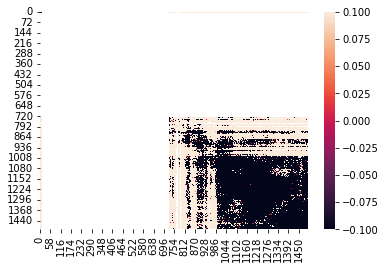

In [99]:
l=5000
u=6500
sns.heatmap(np.log2(hic_mat[l:u,l:u]))

/home/nedooshki/miniconda3/envs/embedding/lib/python3.6/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/nedooshki/miniconda3/envs/embedding/lib/python3.6/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

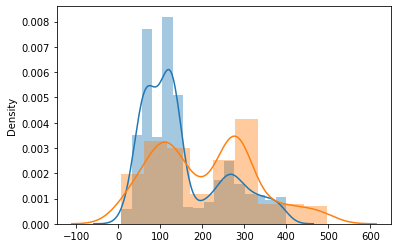

In [66]:
sns.distplot(abs(f2.loc[:,0]-f2.loc[:,1]), label='spin test')
mine = abs(f.loc[:,'first_index']-f.loc[:,'second_index'])
sns.distplot(mine[mine<500], label='mine')